## ⏳ 1. Package Installation & Data Upload

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from math import sqrt
from scipy.stats import randint as sp_randint, uniform

In [ ]:
!pip install scikit-optimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
!pip install hyperopt
from hyperopt import hp
from hyperopt import STATUS_OK
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
!pip install --upgrade numpy scikit-learn scikit-optimize
from scipy.stats import expon, reciprocal

In [ ]:
!pip install shap
import shap

In [ ]:
# import the original dat
df = pd.read_csv("/content/sleep_merged.tsv", sep="\t", index_col = 0)
df.head()

,Genus,Order,Vore,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger
Species,,,,,,,,,,,,,,,
African elephant,Loxodonta,Proboscidea,herbi,vu,6654.000,5712.0,3.3,20.7,NaN,NaN,38.6,645.0,3.0,5.0,3.0
African giant pouched rat,Cricetomys,Rodentia,omni,NaN,1.000,6.6,8.3,15.7,6.3,2.0,4.5,42.0,3.0,1.0,3.0
African striped mouse,Rhabdomys,Rodentia,omni,NaN,0.044,0.0,8.7,15.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arctic fox,Vulpes,Carnivora,carni,NaN,3.380,44.5,12.5,11.5,NaN,NaN,14.0,60.0,1.0,1.0,1.0
Arctic ground squirrel,Spermophilus,Rodentia,herbi,lc,0.920,5.7,16.6,7.4,NaN,NaN,NaN,25.0,5.0,2.0,3.0


## ⏳ 2. Data Checking

In [ ]:
# check whether the index is unique - Yes
df.index.is_unique

True

In [ ]:
# Checking for Duplicates
dups = df.duplicated()
dups.value_counts() #There are 165 Duplicated rows

False    87
dtype: int64

###❌ 2.1 Missing Values


In [ ]:
# define a function to show the missing values
def pct_missing_values(dataframe):
  values_list = list()
  cols_list = list()
  for col in dataframe.columns:
    pct_missing = np.mean(dataframe[col].isnull())*100
    cols_list.append(col)
    values_list.append(pct_missing)
  pct_missing_df = pd.DataFrame()
  pct_missing_df['Column'] = cols_list
  pct_missing_df['pct_missing'] = values_list
  # sort the column by the pct of missing values
  pct_missing_df = pct_missing_df.sort_values(by="pct_missing", ascending=True)
  return pct_missing_df

pct_missing_values(df)

,Column,pct_missing
0,Genus,0.000000
1,Order,0.000000
2,Vore,0.000000
4,BodyWt,0.000000
5,BrainWt,0.000000
6,TotalSleep,0.000000
7,Awake,0.000000
9,Dreaming,27.586207
3,Conservation,33.333333
12,Predation,33.333333


In [ ]:
# How many NaN ?
print(f"Number Total Rows: {df.shape[0]}")
print(f"Number of NaN Values By Column: \n{df.isna().sum()}")

Number Total Rows: 87
Number of NaN Values By Column: 
Genus            0
Order            0
Vore             0
Conservation    29
BodyWt           0
BrainWt          0
TotalSleep       0
Awake            0
NonDreaming     40
Dreaming        24
LifeSpan        33
Gestation       33
Predation       29
Exposure        29
Danger          29
dtype: int64


In [ ]:
df.describe()

,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger
count,87.000000,87.000000,87.000000,87.000000,47.000000,63.000000,54.000000,54.000000,58.000000,58.000000,58.000000
mean,161.384310,196.405287,10.608046,13.393103,8.736170,1.979365,20.240741,139.268519,2.844828,2.362069,2.586207
std,768.846727,793.628150,4.465793,4.467481,3.679522,1.474204,18.757011,144.696322,1.496214,1.575005,1.426989
min,0.005000,0.000000,1.900000,4.100000,2.100000,0.100000,2.000000,12.000000,1.000000,1.000000,1.000000
25%,0.202500,0.000000,8.150000,10.250000,6.300000,0.900000,6.125000,36.750000,2.000000,1.000000,1.000000
50%,2.000000,5.500000,10.300000,13.700000,8.400000,1.800000,15.100000,79.000000,3.000000,2.000000,2.000000
75%,43.165000,64.000000,13.750000,15.850000,11.000000,2.500000,28.000000,195.000000,4.000000,4.000000,4.000000
max,6654.000000,5712.000000,19.900000,22.100000,17.900000,6.600000,100.000000,645.000000,5.000000,5.000000,5.000000


###⏰2.2 Classfications between numercial and categorical


In [ ]:
df_num = df.select_dtypes(include='number')
df_cat = df.select_dtypes(include=['object','category'])
print(df_num.columns)
print(df_cat.columns)

""" however, predation, exposure and danger should be categorical
values in df_cat, and df_cat should exclude Genus and Order, since there are too many categories in these 2 cols"""

Index(['BodyWt', 'BrainWt', 'TotalSleep', 'Awake', 'NonDreaming', 'Dreaming',
       'LifeSpan', 'Gestation', 'Predation', 'Exposure', 'Danger'],
      dtype='object')
Index(['Genus', 'Order', 'Vore', 'Conservation'], dtype='object')


' however, predation, exposure and danger should be categorical\nvalues in df_cat, and df_cat should exclude Genus and Order, since there are too many categories in these 2 cols'

In [ ]:
# Define numerical and categorical columns based on specific criteria
num_cols = ['BodyWt', 'BrainWt', 'TotalSleep', 'Awake', 'NonDreaming', 'Dreaming',
            'LifeSpan', 'Gestation']
cat_cols = ['Vore', 'Conservation', 'Predation', 'Exposure', 'Danger']

# Now explicitly select these columns
df_num = df[num_cols]
df_cat = df[cat_cols]

# Print the columns to verify
print(df_num.columns)
print(df_cat.columns)

Index(['BodyWt', 'BrainWt', 'TotalSleep', 'Awake', 'NonDreaming', 'Dreaming',
       'LifeSpan', 'Gestation'],
      dtype='object')
Index(['Vore', 'Conservation', 'Predation', 'Exposure', 'Danger'], dtype='object')


In [ ]:
df.info()
df.describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T
print("we have", len(df_num.columns), "numerical variables, and ", len(df_cat.columns), "categorical variables." )

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, African elephant to Western american chipmunk
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Genus         87 non-null     object 
 1   Order         87 non-null     object 
 2   Vore          87 non-null     object 
 3   Conservation  58 non-null     object 
 4   BodyWt        87 non-null     float64
 5   BrainWt       87 non-null     float64
 6   TotalSleep    87 non-null     float64
 7   Awake         87 non-null     float64
 8   NonDreaming   47 non-null     float64
 9   Dreaming      63 non-null     float64
 10  LifeSpan      54 non-null     float64
 11  Gestation     54 non-null     float64
 12  Predation     58 non-null     float64
 13  Exposure      58 non-null     float64
 14  Danger        58 non-null     float64
dtypes: float64(11), object(4)
memory usage: 12.9+ KB
we have 8 numerical variables, and  5 categorical variables.


###⭕ 2.3 Outliers

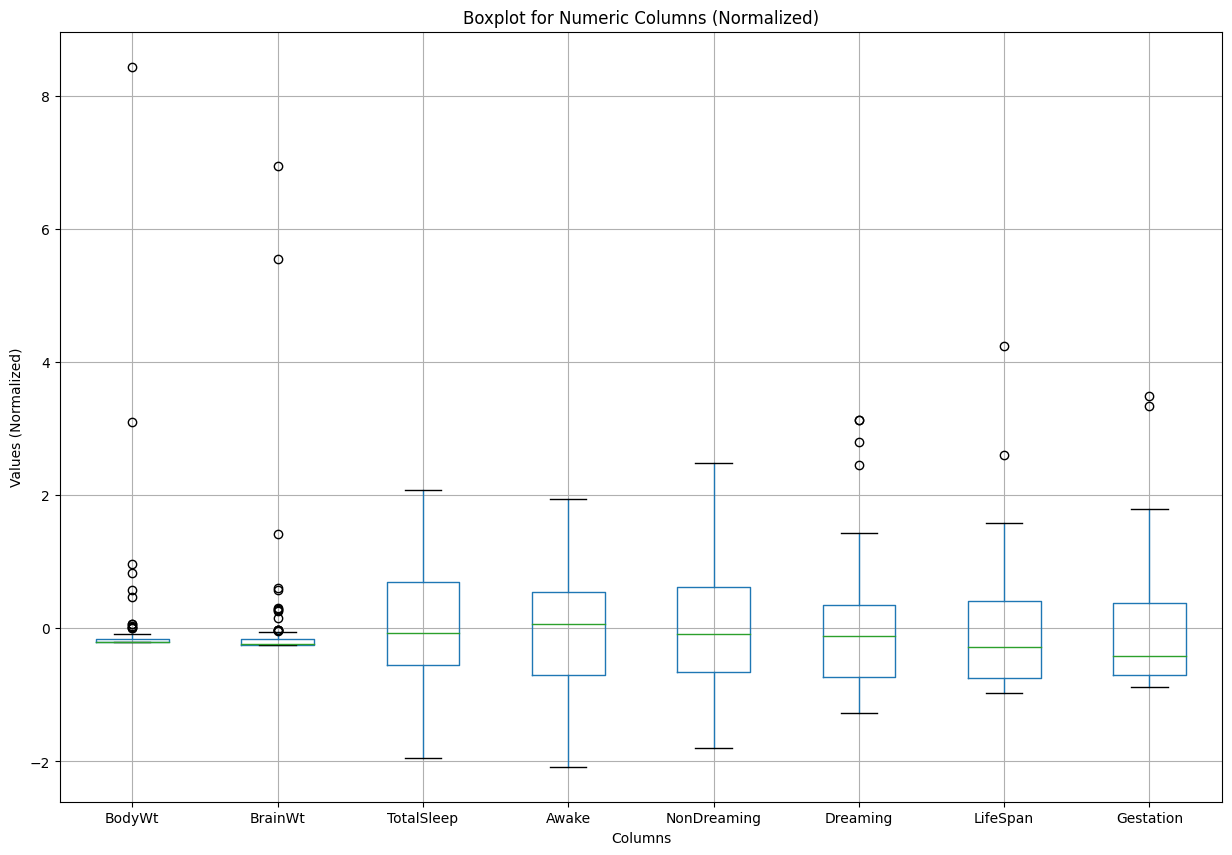

In [ ]:
# boxplots for numeric variables

# normalize the data
df_num_normalized = (df_num - df_num.mean()) / df_num.std()

# generate the boxplot for all the numeric columns
boxplot = df_num_normalized.boxplot(figsize=(15,10))

# set the title and axis labels
boxplot.set_title('Boxplot for Numeric Columns (Normalized)')
boxplot.set_xlabel('Columns')
boxplot.set_ylabel('Values (Normalized)')

# show the plot
plt.show()

In [ ]:
df.sort_values(by='BodyWt', ascending=False).head(5)

,Genus,Order,Vore,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger
Species,,,,,,,,,,,,,,,
African elephant,Loxodonta,Proboscidea,herbi,vu,6654.000,5712.0,3.3,20.70,NaN,NaN,38.6,645.0,3.0,5.0,3.0
Asian elephant,Elephas,Proboscidea,herbi,en,2547.000,4603.0,3.9,20.10,2.1,1.8,69.0,624.0,3.0,5.0,4.0
Giraffe,Giraffa,Artiodactyla,herbi,cd,899.995,680.0,1.9,22.10,NaN,0.3,28.0,400.0,5.0,5.0,5.0
Pilot whale,Globicephalus,Cetacea,carni,cd,800.000,0.0,2.7,21.35,NaN,0.1,NaN,NaN,NaN,NaN,NaN
Cow,Bos,Artiodactyla,herbi,domesticated,600.000,423.0,4.0,20.00,3.2,0.7,30.0,281.0,5.0,5.0,5.0


In [ ]:
df.sort_values(by='BrainWt', ascending=False).head(5)

,Genus,Order,Vore,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger
Species,,,,,,,,,,,,,,,
African elephant,Loxodonta,Proboscidea,herbi,vu,6654.000,5712.0,3.3,20.7,NaN,NaN,38.6,645.0,3.0,5.0,3.0
Asian elephant,Elephas,Proboscidea,herbi,en,2547.000,4603.0,3.9,20.1,2.1,1.8,69.0,624.0,3.0,5.0,4.0
Human,Homo,Primates,omni,NaN,62.000,1320.0,8.0,16.0,6.1,1.9,100.0,267.0,1.0,1.0,1.0
Giraffe,Giraffa,Artiodactyla,herbi,cd,899.995,680.0,1.9,22.1,NaN,0.3,28.0,400.0,5.0,5.0,5.0
Horse,Equus,Perissodactyla,herbi,domesticated,521.000,655.0,2.9,21.1,2.1,0.8,46.0,336.0,5.0,5.0,5.0


In [ ]:
# Sort the DataFrame by 'BodyWt' in descending order and then skip the top 5 rows
df_outliers_removed = df.sort_values(by='BodyWt', ascending=False).iloc[5:]

# Now df_outliers_removed contains the following rows after removing the top 5 rows with the largest 'BodyWt'

### 📊 Visualization for Numerical & Categorical Variables

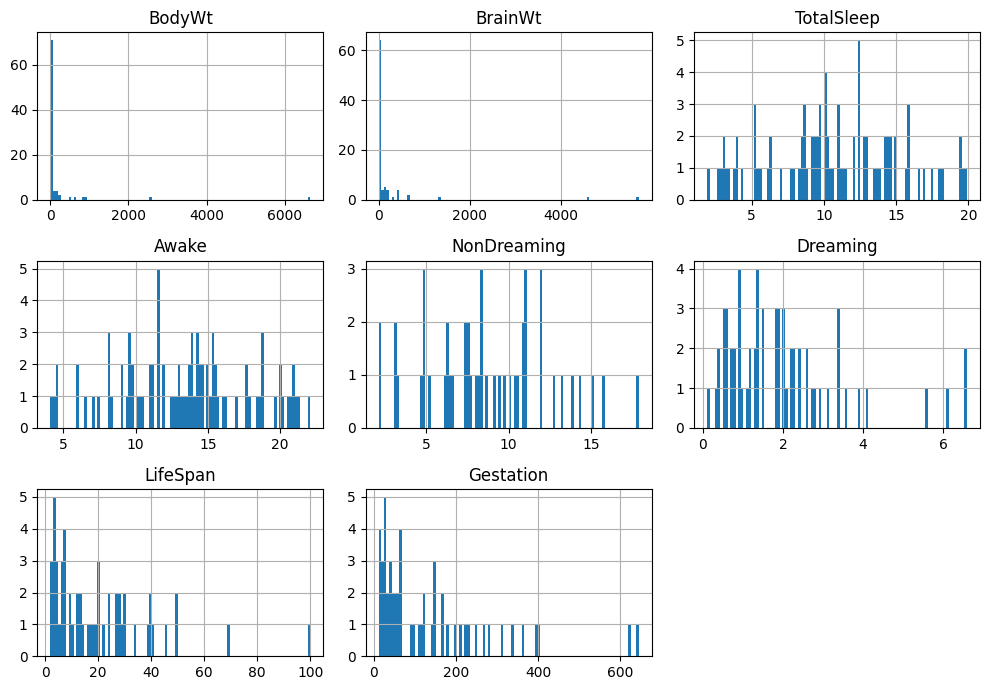

In [ ]:
# plot histograms for all continuous variables
df_num.hist(bins=100, figsize=(10,7))
plt.tight_layout()
plt.show()

<Figure size 1600x1200 with 0 Axes>

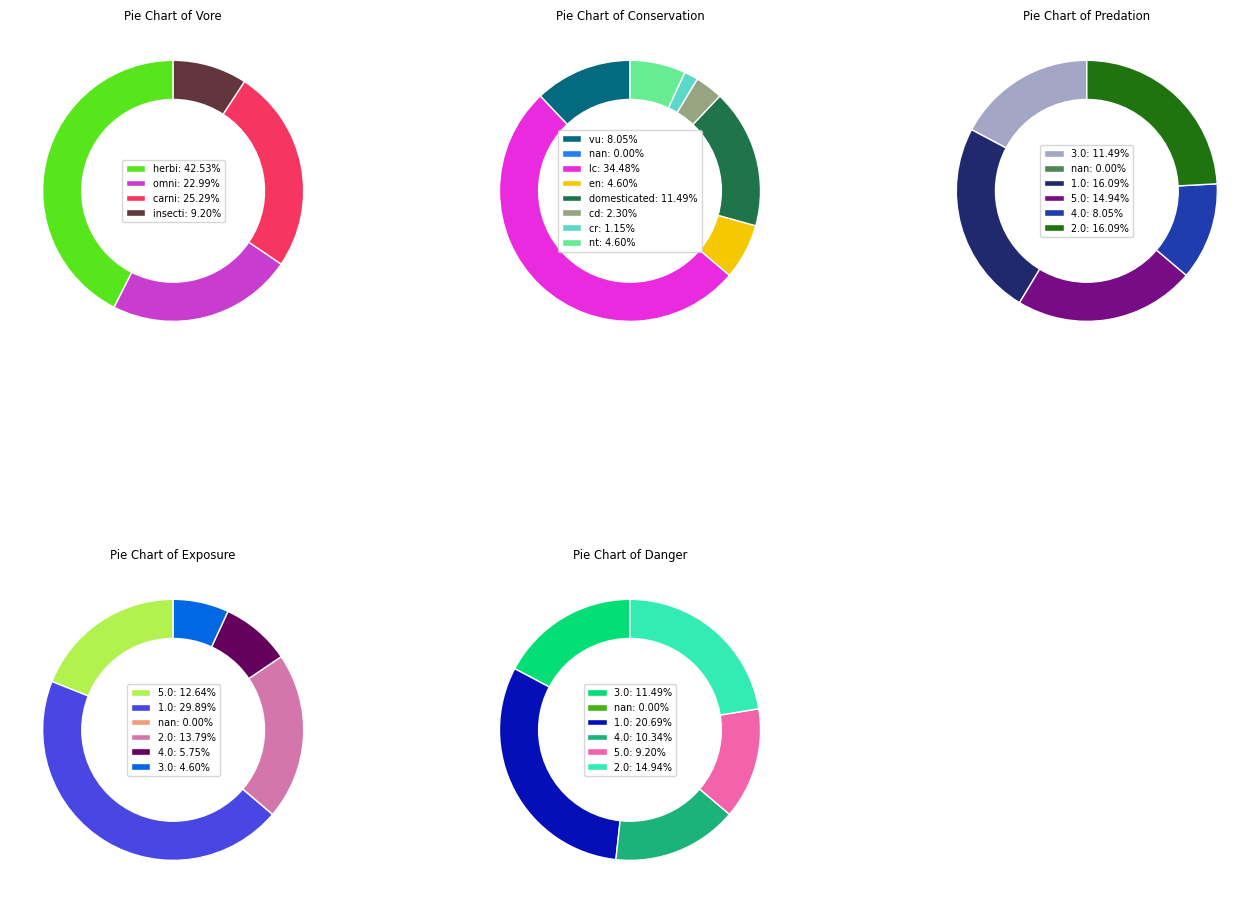

In [ ]:
# # part 2:Donut plots for categorical variables
# return the label dataframe
# Define the number of rows and columns for the grid
num_rows = 2
num_columns = 3

# Create a new figure and specify the size
fig = plt.figure(figsize=(16, 12))  # Increase the size of the plot

for x in df_cat.columns:
    i = df_cat.columns.get_loc(x)

# Create a new figure and specify the size
fig = plt.figure(figsize=(16, 12))

# Loop through the categorical columns
for i, x in enumerate(df_cat.columns):
    # Calculate the subplot position based on the index
    position = i + 1

    # Create the subplot
    ax = fig.add_subplot(num_rows, num_columns, position)

    # Count unique categories and sizes
    unique_categories = df_cat[x].unique()
    sizes = []
    labels = []
    colors = []
    for unique in unique_categories:
        sizes.append(df_cat[df_cat[x] == unique].shape[0])
        labels.append(f"{unique}: {sizes[-1] / df_cat[x].shape[0] * 100:.2f}%")
        colors.append((random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))

    # Plot the donut chart
    y = ax.pie(sizes, colors=colors, startangle=90, radius=1, wedgeprops=dict(width=0.7, edgecolor='w'))
    ax.set(aspect="equal")
    ax.set_title(f"Pie Chart of {x}", fontsize='small')
    # Add circle at the center
    my_circle = plt.Circle((0, 0), 0.7, color='white')
    p = plt.gcf()
    p.gca().add_artist(my_circle)

    # Add legend with smaller font size
    ax.legend(labels, loc="center", fontsize='x-small')  # Reduce the font size

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Show the plot
plt.show()

### 📊 Correlation by Scatter Plot and Heatmap

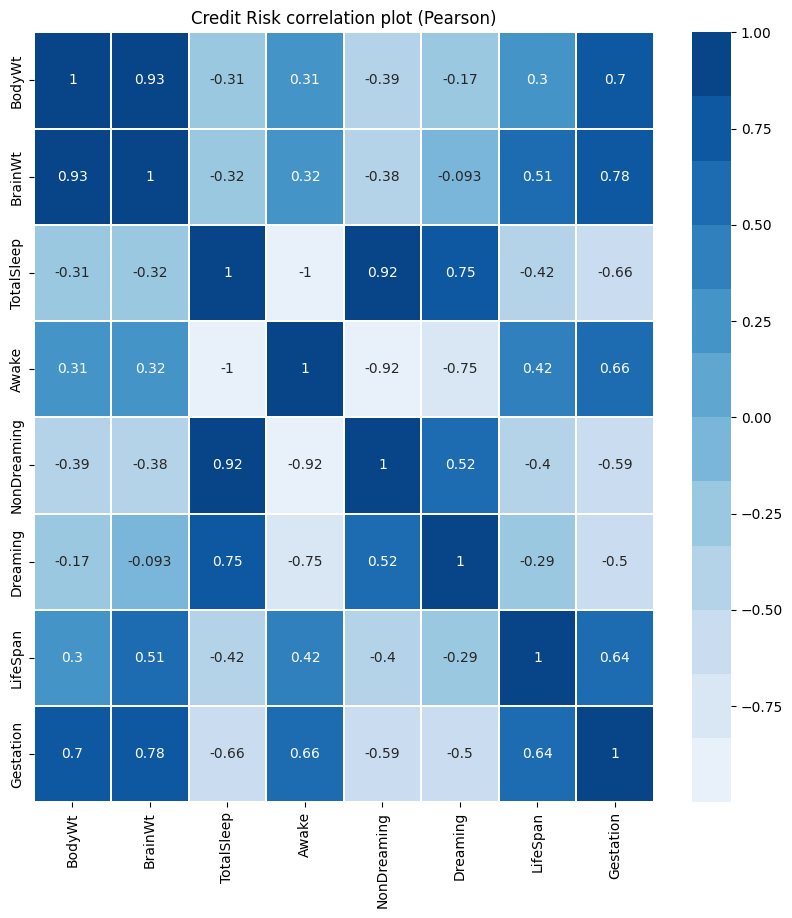

In [ ]:
#Heatmap

plt.figure(figsize = (10,10))
plt.title('Credit Risk correlation plot (Pearson)')
corr = df_num.corr()
colormap = sns.color_palette("Blues",12)
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,annot=True,linewidths=.1,cmap=colormap)
plt.show()

Text(0.5, 1.0, 'Chi-square test p-values for pairs of categorical variables')

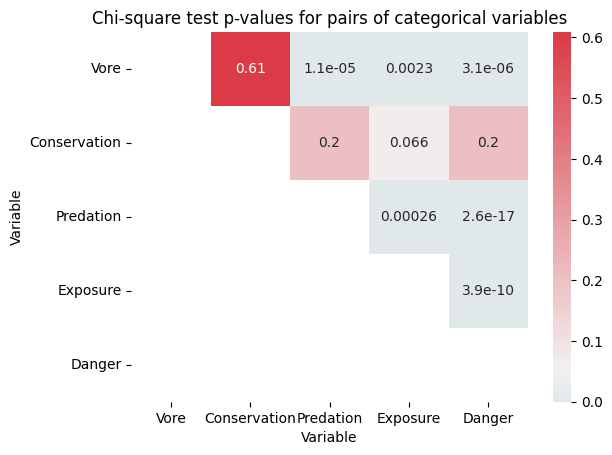

In [ ]:
# check the multicollinearity among categorical variables by Chi
import itertools
from scipy.stats import chi2_contingency

# Get all pairs of categorical variables
var_pairs = list(itertools.combinations(df_cat.columns, 2))

# Initialize matrix of p-values
pval_matrix = np.zeros((len(df_cat.columns), len(df_cat.columns)))

# Perform chi-square test for each pair of variables and fill in p-value matrix
for i, var1 in enumerate(df_cat.columns):
    for j, var2 in enumerate(df_cat.columns):
        if i != j:
            contingency_table = pd.crosstab(df_cat[var1], df_cat[var2])
            chi2, pval, dof, expected = chi2_contingency(contingency_table)
            pval_matrix[i,j] = pval

# Create heatmap
mask = np.tril(np.ones_like(pval_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(pval_matrix, mask=mask, cmap=cmap, center=0.05, annot=True, fmt=".2g",
                 xticklabels=df_cat.columns, yticklabels=df_cat.columns)

# Set axis labels and title
ax.set_xlabel('Variable')
ax.set_ylabel('Variable')
ax.set_title('Chi-square test p-values for pairs of categorical variables')

In [ ]:
df.Conservation.unique()

array(['vu', nan, 'lc', 'en', 'domesticated', 'cd', 'cr', 'nt'],
      dtype=object)

<Axes: xlabel='LifeSpan', ylabel='TotalSleep'>

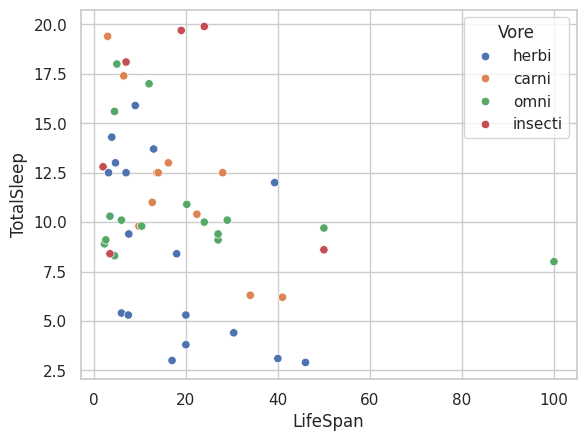

In [ ]:
sns.set(style='whitegrid')
sns.scatterplot(x="LifeSpan", y="TotalSleep", hue="Vore", data=df_outliers_removed)

<Axes: xlabel='BodyWt', ylabel='TotalSleep'>

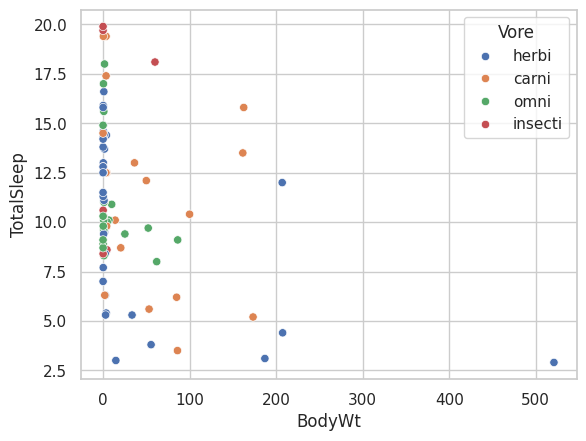

In [ ]:
sns.set(style='whitegrid')
sns.scatterplot(x="BodyWt", y="TotalSleep", hue="Vore", data=df_outliers_removed)

<Axes: xlabel='Gestation', ylabel='TotalSleep'>

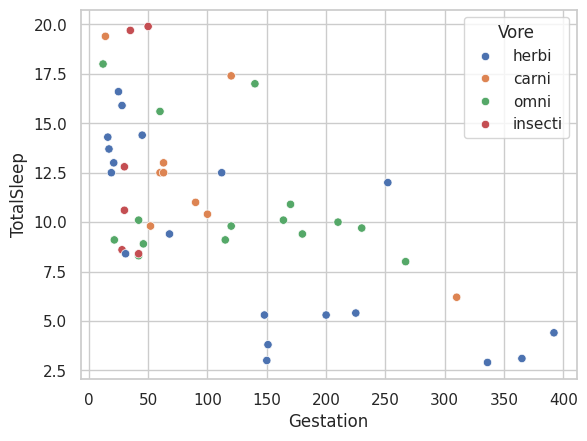

In [ ]:
sns.set(style='whitegrid')
sns.scatterplot(x="Gestation", y="TotalSleep", hue="Vore", data=df_outliers_removed)

In [ ]:
df_num_outliers_removed = df_outliers_removed[['BodyWt', 'BrainWt', 'TotalSleep', 'Dreaming', 'LifeSpan', 'Gestation']]

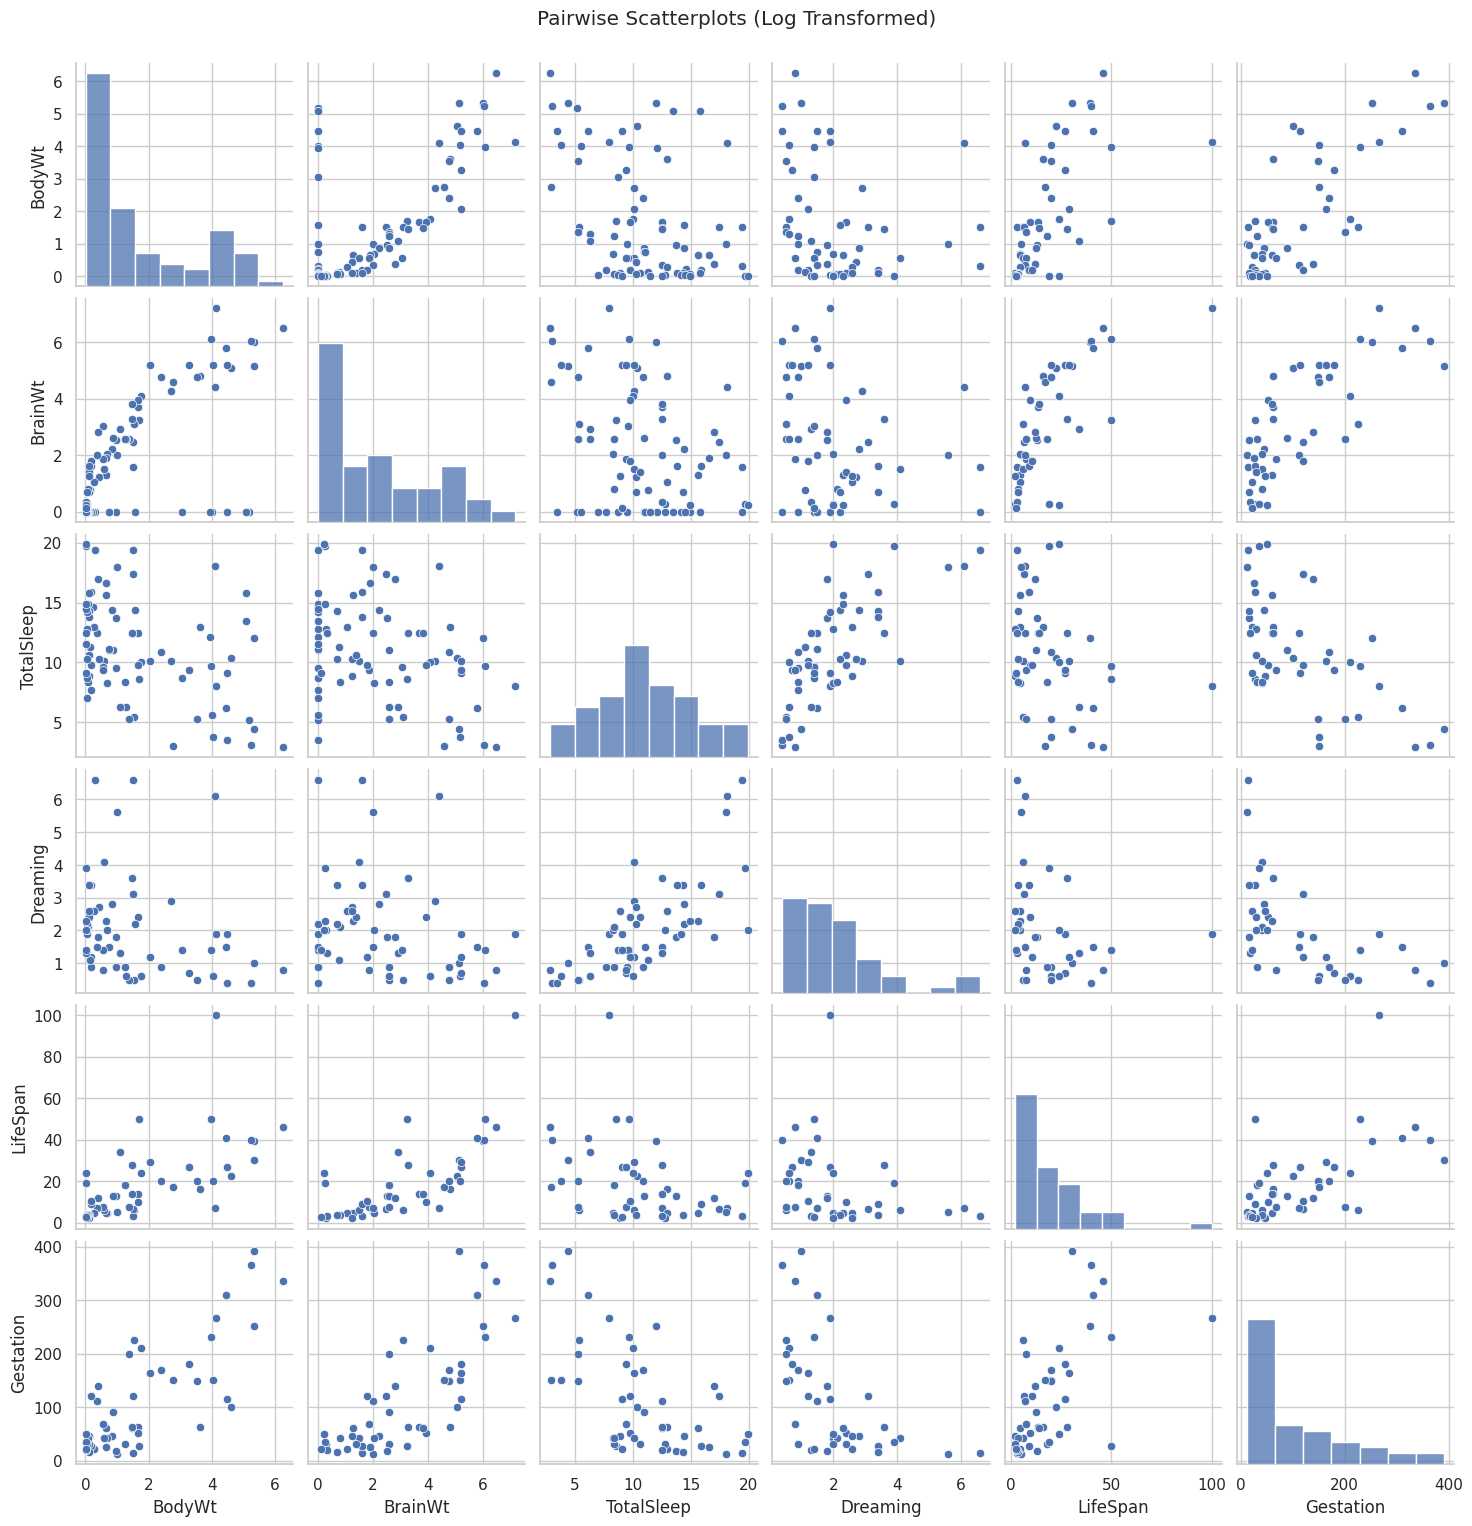

'\ndf_num2 = pd.DataFrame(data)\n\n# Creating pairwise scatter plots\nsns.pairplot(df_num2)\nplt.suptitle("Pairwise Scatterplots", y=1.02) # Adjust title position\nplt.show()'

In [ ]:
# Sample data creation
np.random.seed(42) # For reproducible results

# Apply log transformation to certain columns to reduce scale effects
df_num_outliers_removed_transformed = df_num_outliers_removed.copy()
df_num_outliers_removed_transformed['BodyWt'] = np.log(df_num_outliers_removed_transformed['BodyWt'] + 1)  # Adding 1 to avoid log(0)
df_num_outliers_removed_transformed['BrainWt'] = np.log(df_num_outliers_removed_transformed['BrainWt'] + 1)

# Creating pairwise scatter plots on the transformed DataFrame
sns.pairplot(df_num_outliers_removed_transformed)
plt.suptitle("Pairwise Scatterplots (Log Transformed)", y=1.02)
plt.show()

"""
df_num2 = pd.DataFrame(data)

# Creating pairwise scatter plots
sns.pairplot(df_num2)
plt.suptitle("Pairwise Scatterplots", y=1.02) # Adjust title position
plt.show()"""

## ⏳ 3. Feature Engineering

In [ ]:
# Check data types of columns in num_cols
print("Numerical Columns and their Data Types:")
print(df_num.dtypes)
print("\n")

# Check data types of columns in cat_cols
print("Categorical Columns and their Data Types:")
print(df_cat.dtypes)

Numerical Columns and their Data Types:
BodyWt         float64
BrainWt        float64
TotalSleep     float64
Awake          float64
NonDreaming    float64
Dreaming       float64
LifeSpan       float64
Gestation      float64
dtype: object


Categorical Columns and their Data Types:
Vore             object
Conservation     object
Predation       float64
Exposure        float64
Danger          float64
dtype: object


In [ ]:
# Imputer for the target variables
target_imputer = SimpleImputer(strategy='median')  # or another strategy like 'mean'

# Impute 'TotalSleep' and 'Dreaming'
df['TotalSleep'] = target_imputer.fit_transform(df[['TotalSleep']])
df['Dreaming'] = target_imputer.fit_transform(df[['Dreaming']])

# Then, isolate your targets again and proceed
y_total_sleep = df['TotalSleep']
y_dreaming = df['Dreaming']

In [ ]:
# Impute missing values in the numerical dataframe and scale
num_imputer = SimpleImputer(strategy='median')
df_num_imputed = num_imputer.fit_transform(df_num)
scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_num_imputed)

# Convert it back to a DataFrame, preserving the original index
df_num_preprocessed = pd.DataFrame(df_num_scaled, index=df_num.index, columns=df_num.columns)

In [ ]:
# Impute missing values with a placeholder and convert to strings
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
df_cat_imputed = cat_imputer.fit_transform(df_cat)
df_cat_imputed_str = pd.DataFrame(df_cat_imputed, index=df_cat.index, columns=df_cat.columns).astype(str)

# Apply one-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore')
df_cat_encoded = encoder.fit_transform(df_cat_imputed_str).toarray()  # Use .toarray() here if you need a dense array

# Convert encoded data back to a DataFrame, preserving the original index
# Note: get_feature_names_out() is available in scikit-learn 0.23 and later. For earlier versions, use get_feature_names().
df_cat_preprocessed = pd.DataFrame(df_cat_encoded, index=df_cat.index, columns=encoder.get_feature_names_out())

print(df_cat_preprocessed.head())

                           Vore_carni  Vore_herbi  Vore_insecti  Vore_omni  \
Species                                                                      
African elephant                  0.0         1.0           0.0        0.0   
African giant pouched rat         0.0         0.0           0.0        1.0   
African striped mouse             0.0         0.0           0.0        1.0   
Arctic fox                        1.0         0.0           0.0        0.0   
Arctic ground squirrel            0.0         1.0           0.0        0.0   

                           Conservation_cd  Conservation_cr  \
Species                                                       
African elephant                       0.0              0.0   
African giant pouched rat              0.0              0.0   
African striped mouse                  0.0              0.0   
Arctic fox                             0.0              0.0   
Arctic ground squirrel                 0.0              0.0   

           

In [ ]:
# Concatenate the numerical and categorical dataframes
X_preprocessed = pd.concat([df_num_preprocessed, df_cat_preprocessed], axis=1)

# Assuming df is the original DataFrame and still contains the target variables
# Now, you can either work with X_preprocessed and y separately or reattach them
df_final = X_preprocessed.copy()
df_final['TotalSleep'] = df.loc[X_preprocessed.index, 'TotalSleep']
df_final['Dreaming'] = df.loc[X_preprocessed.index, 'Dreaming']

In [ ]:
df_final.columns

Index(['BodyWt', 'BrainWt', 'TotalSleep', 'Awake', 'NonDreaming', 'Dreaming',
       'LifeSpan', 'Gestation', 'Vore_carni', 'Vore_herbi', 'Vore_insecti',
       'Vore_omni', 'Conservation_cd', 'Conservation_cr',
       'Conservation_domesticated', 'Conservation_en', 'Conservation_lc',
       'Conservation_missing', 'Conservation_nt', 'Conservation_vu',
       'Predation_1.0', 'Predation_2.0', 'Predation_3.0', 'Predation_4.0',
       'Predation_5.0', 'Predation_missing', 'Exposure_1.0', 'Exposure_2.0',
       'Exposure_3.0', 'Exposure_4.0', 'Exposure_5.0', 'Exposure_missing',
       'Danger_1.0', 'Danger_2.0', 'Danger_3.0', 'Danger_4.0', 'Danger_5.0',
       'Danger_missing'],
      dtype='object')

In [ ]:
# Drop 'TotalSleep' and 'Awake' columns from df_final
df_final_adjusted = df_final.drop(['TotalSleep', 'Dreaming', 'Awake', 'NonDreaming'], axis=1)

# Identify columns ending with 'missing'
columns_to_drop = [col for col in df_final_adjusted.columns if col.endswith('missing')]

# Drop these columns from df_final
df_final_adjusted = df_final_adjusted.drop(columns=columns_to_drop) # Now df_final_cleaned is your adjusted DataFrame without the 'missing' columns

# Calculate mutual information scores for 'TotalSleep'
mi_scores_total_sleep = mutual_info_regression(df_final_adjusted, y_total_sleep)

# Calculate mutual information scores for 'Dreaming'
mi_scores_dreaming = mutual_info_regression(df_final_adjusted, y_dreaming)

# Normalize the MI scores for comparison purposes
mi_scores_total_sleep_normalized = mi_scores_total_sleep / np.max(mi_scores_total_sleep)
mi_scores_dreaming_normalized = mi_scores_dreaming / np.max(mi_scores_dreaming)

# Create Series for the MI scores
features = df_final_adjusted.columns
mi_scores_total_sleep_series = pd.Series(mi_scores_total_sleep_normalized, index=features).sort_values(ascending=False)
mi_scores_dreaming_series = pd.Series(mi_scores_dreaming_normalized, index=features).sort_values(ascending=False)

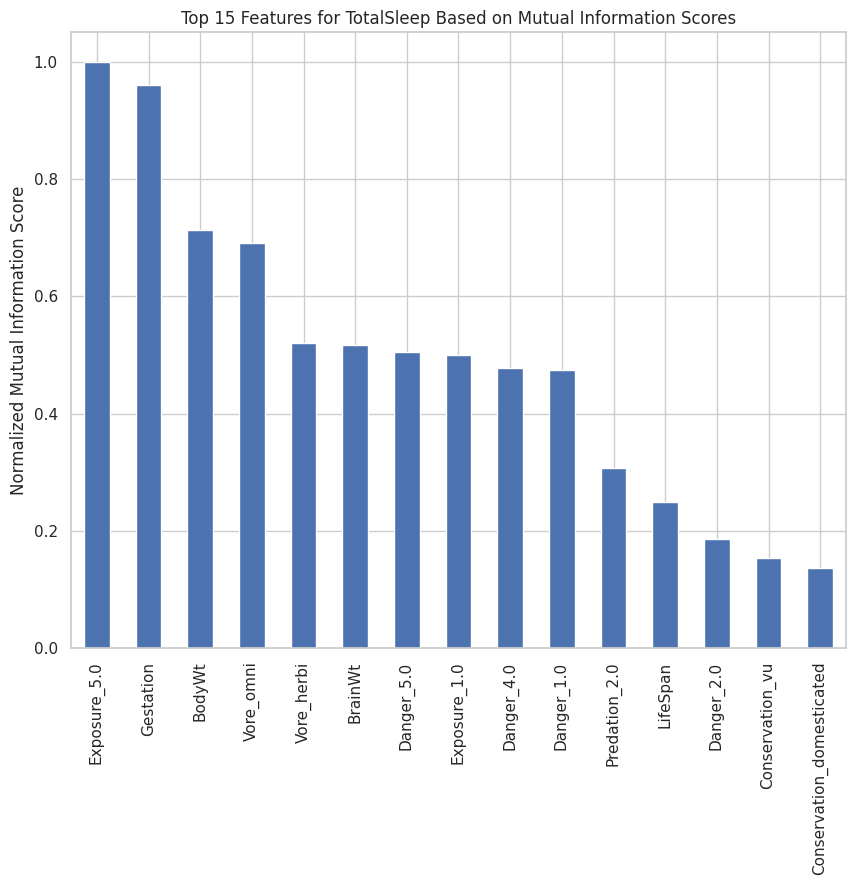

In [ ]:
# Plot for 'TotalSleep'
plt.figure(figsize=(10, 8))
mi_scores_total_sleep_series.head(15).plot(kind='bar')
plt.title('Top 15 Features for TotalSleep Based on Mutual Information Scores')
plt.ylabel('Normalized Mutual Information Score')
plt.show()

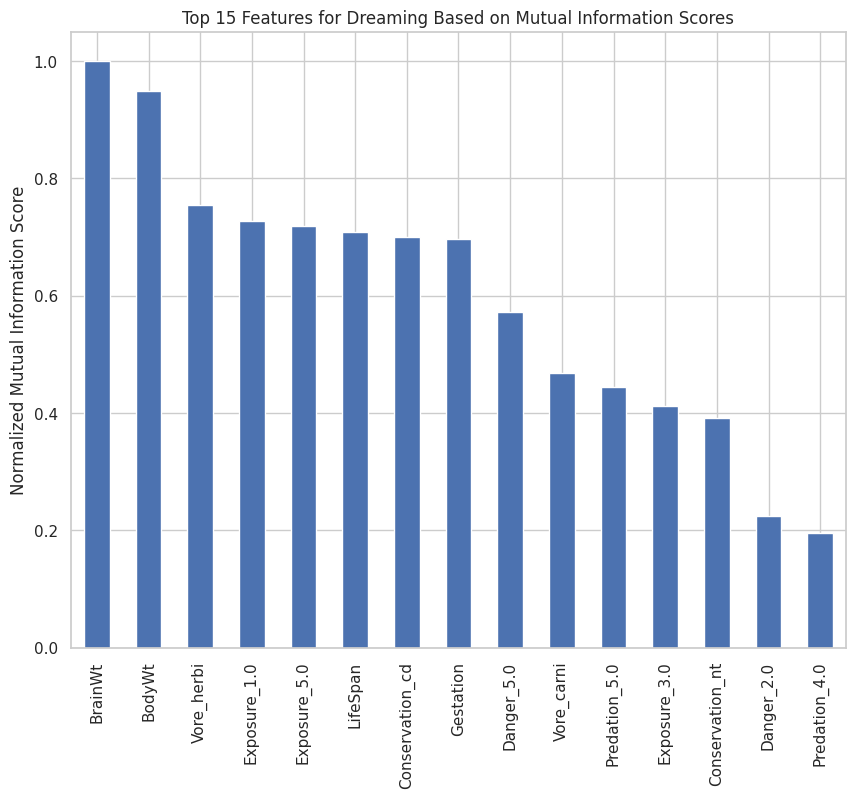

In [ ]:
# Plot for 'Dreaming'
plt.figure(figsize=(10, 8))
mi_scores_dreaming_series.head(15).plot(kind='bar')
plt.title('Top 15 Features for Dreaming Based on Mutual Information Scores')
plt.ylabel('Normalized Mutual Information Score')
plt.show()

In [ ]:
# Top 15 features for TotalSleep
top_15_total_sleep = mi_scores_total_sleep_series.head(15)
print("Top 15 Features for TotalSleep:")
print(top_15_total_sleep)

# Top 15 features for Dreaming
top_15_dreaming = mi_scores_dreaming_series.head(15)
print("\nTop 15 Features for Dreaming:")
print(top_15_dreaming)

Top 15 Features for TotalSleep:
Exposure_5.0                 1.000000
Gestation                    0.959478
BodyWt                       0.712693
Vore_omni                    0.691463
Vore_herbi                   0.519693
BrainWt                      0.516727
Danger_5.0                   0.504478
Exposure_1.0                 0.499721
Danger_4.0                   0.477441
Danger_1.0                   0.473735
Predation_2.0                0.307078
LifeSpan                     0.249380
Danger_2.0                   0.186749
Conservation_vu              0.154000
Conservation_domesticated    0.136477
dtype: float64

Top 15 Features for Dreaming:
BrainWt            1.000000
BodyWt             0.949058
Vore_herbi         0.754061
Exposure_1.0       0.727626
Exposure_5.0       0.718592
LifeSpan           0.708603
Conservation_cd    0.700219
Gestation          0.696018
Danger_5.0         0.572753
Vore_carni         0.469193
Predation_5.0      0.444037
Exposure_3.0       0.412434
Conservation_nt 

##⏳4. Modeling for TotalSleep and Dreaming


In [ ]:
# Select the top 15 features for TotalSleep and Dreaming based on MI
X_total_sleep_top_15 = df_final_adjusted[top_15_total_sleep.index]
X_dreaming_top_15 = df_final_adjusted[top_15_dreaming.index]

# Split data for TotalSleep
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(X_total_sleep_top_15, y_total_sleep, test_size=0.2, random_state=42)

# Split data for Dreaming
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_dreaming_top_15, y_dreaming, test_size=0.2, random_state=42)

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    return rmse

In [ ]:
# Initialize models
rf = RandomForestRegressor(random_state=42)
gbm = GradientBoostingRegressor(random_state=42)
svr = SVR()

In [ ]:
# Train and evaluate for TotalSleep using top 15 features
rf_rmse_ts_top_15 = train_and_evaluate(rf, X_train_ts, y_train_ts, X_test_ts, y_test_ts)
gbm_rmse_ts_top_15 = train_and_evaluate(gbm, X_train_ts, y_train_ts, X_test_ts, y_test_ts)
svr_rmse_ts_top_15 = train_and_evaluate(svr, X_train_ts, y_train_ts, X_test_ts, y_test_ts)

print(f"TotalSleep with Top 15 Features - RF RMSE: {rf_rmse_ts_top_15}")
print(f"TotalSleep with Top 15 Features - GBM RMSE: {gbm_rmse_ts_top_15}")
print(f"TotalSleep with Top 15 Features - SVR RMSE: {svr_rmse_ts_top_15}")

TotalSleep with Top 15 Features - RF RMSE: 4.39524344541283
TotalSleep with Top 15 Features - GBM RMSE: 4.405914362803204
TotalSleep with Top 15 Features - SVR RMSE: 4.301763686489456


In [ ]:
# Train and evaluate for Dreaming using top 15 features
rf_rmse_d_top_15 = train_and_evaluate(rf, X_train_d, y_train_d, X_test_d, y_test_d)
gbm_rmse_d_top_15 = train_and_evaluate(gbm, X_train_d, y_train_d, X_test_d, y_test_d)
svr_rmse_d_top_15 = train_and_evaluate(svr, X_train_d, y_train_d, X_test_d, y_test_d)

print(f"Dreaming with Top 15 Features - RF RMSE: {rf_rmse_d_top_15}")
print(f"Dreaming with Top 15 Features - GBM RMSE: {gbm_rmse_d_top_15}")
print(f"Dreaming with Top 15 Features - SVR RMSE: {svr_rmse_d_top_15}")

Dreaming with Top 15 Features - RF RMSE: 1.377607325925804
Dreaming with Top 15 Features - GBM RMSE: 1.3228131334719162
Dreaming with Top 15 Features - SVR RMSE: 1.3150217112634284


In [ ]:
# Try to serialize X_train_ts and y_train_ts
try:
    pickle.dumps(X_train_ts)
    pickle.dumps(y_train_ts)
    print("X_train_ts and y_train_ts are serializable.")
except Exception as e:
    print(f"Error during serialization: {e}")

X_train_ts and y_train_ts are serializable.


In [ ]:
# Define the parameter grid manually
param_grid_svr = {
    'C': [1, 10, 100],  # Regularization parameter
    'epsilon': [0.01, 0.1, 1],  # Epsilon in the epsilon-SVR model
    'kernel': ['rbf', 'linear']  # Kernel type
}

grid_search_svr_ts = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='neg_root_mean_squared_error', n_jobs=1)
grid_search_svr_ts.fit(X_train_ts, y_train_ts)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=1,
             param_grid={'C': [1, 10, 100], 'epsilon': [0.01, 0.1, 1],
                         'kernel': ['rbf', 'linear']},
             scoring='neg_root_mean_squared_error')

In [ ]:
# Inspect the data types and shapes
print("X_train_ts type:", type(X_train_ts))
print("X_train_ts shape:", X_train_ts.shape)
print("y_train_ts type:", type(y_train_ts))
print("y_train_ts shape:", y_train_ts.shape)

# Ensure no missing values
print("Missing values in X_train_ts:", X_train_ts.isnull().sum().sum())
print("Missing values in y_train_ts:", y_train_ts.isnull().sum())


X_train_ts type: <class 'pandas.core.frame.DataFrame'>
X_train_ts shape: (69, 15)
y_train_ts type: <class 'pandas.core.series.Series'>
y_train_ts shape: (69,)
Missing values in X_train_ts: 0
Missing values in y_train_ts: 0


In [ ]:
try:
    svr = SVR()
    svr.fit(X_train_ts, y_train_ts)
    print("Simple SVR model fit successfully.")
except Exception as e:
    print("Error fitting SVR model:", e)


Simple SVR model fit successfully.


In [ ]:
best_score = float('inf')
best_params_ts = {}
for C in param_grid_svr['C']:
    for epsilon in param_grid_svr['epsilon']:
        for kernel in param_grid_svr['kernel']:
            svr = SVR(C=C, epsilon=epsilon, kernel=kernel)
            svr.fit(X_train_ts, y_train_ts)
            score = sqrt(mean_squared_error(y_test_ts, svr.predict(X_test_ts)))
            if score < best_score:
                best_score = score
                best_params_ts = {'C': C, 'epsilon': epsilon, 'kernel': kernel}

print("Best parameters found manually:", best_params_ts)
print("Best RMSE score found manually:", best_score)


Best parameters found manually: {'C': 1, 'epsilon': 0.01, 'kernel': 'linear'}
Best RMSE score found manually: 4.198969597277249


In [ ]:
# Deploy the model with the best parameters found for TotalSleep
svr_best_ts = SVR(C=1, epsilon=0.01, kernel='linear')
svr_best_ts.fit(X_train_ts, y_train_ts)

# Predict on the test set
y_pred_ts = svr_best_ts.predict(X_test_ts)

# Calculate RMSE for the final evaluation
rmse_ts_final = sqrt(mean_squared_error(y_test_ts, y_pred_ts))
print(f"Final RMSE for TotalSleep with the best model: {rmse_ts_final}")


Final RMSE for TotalSleep with the best model: 4.198969597277249


In [ ]:
best_score_d = float('inf')
best_params_ts_d = {}

# Define the parameter grid manually
param_grid_svr = {
    'C': [1, 10, 100],  # Regularization parameter
    'epsilon': [0.01, 0.1, 1],  # Epsilon in the epsilon-SVR model
    'kernel': ['rbf', 'linear']  # Kernel type
}

# Iterate over each combination of hyperparameters
for C in param_grid_svr['C']:
    for epsilon in param_grid_svr['epsilon']:
        for kernel in param_grid_svr['kernel']:
            svr = SVR(C=C, epsilon=epsilon, kernel=kernel)
            svr.fit(X_train_d, y_train_d)
            score = sqrt(mean_squared_error(y_test_d, svr.predict(X_test_d)))
            if score < best_score_d:
                best_score_d = score
                best_params_ts_d = {'C': C, 'epsilon': epsilon, 'kernel': kernel}

print("Best parameters found manually for Dreaming:", best_params_ts_d)
print("Best RMSE score found manually for Dreaming:", best_score_d)

Best parameters found manually for Dreaming: {'C': 10, 'epsilon': 1, 'kernel': 'rbf'}
Best RMSE score found manually for Dreaming: 1.3117145536598678


In [ ]:
# Deploy the model with the best parameters found
svr_best_d = SVR(C=best_params_ts_d['C'], epsilon=best_params_ts_d['epsilon'], kernel=best_params_ts_d['kernel'])
svr_best_d.fit(X_train_d, y_train_d)

# Predict on the test set
y_pred_d = svr_best_d.predict(X_test_d)

# Calculate RMSE for the final evaluation
rmse_d_final = sqrt(mean_squared_error(y_test_d, y_pred_d))
print(f"Final RMSE for Dreaming with the best model: {rmse_d_final}")

Final RMSE for Dreaming with the best model: 1.3117145536598678



Feature Importance for TotalSleep:
Exposure_5.0                -2.649448
Danger_5.0                  -2.342158
Predation_2.0                1.851107
Conservation_vu             -1.485337
Vore_herbi                   1.242635
Danger_1.0                   1.157384
Danger_2.0                  -1.148893
Exposure_1.0                 1.049466
BodyWt                      -1.047894
LifeSpan                    -0.868966
BrainWt                      0.868389
Gestation                   -0.713658
Vore_omni                    0.329877
Conservation_domesticated   -0.170995
Danger_4.0                   0.007501
dtype: float64


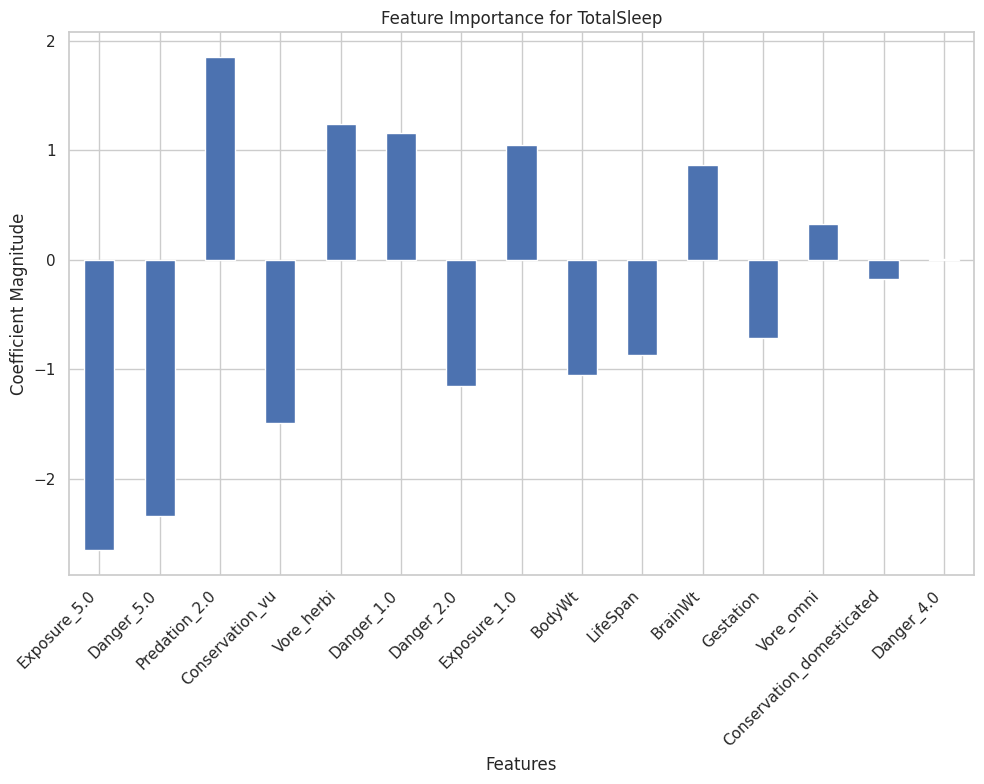

In [ ]:
if best_params_ts['kernel'] == 'linear':
    # svr_best_ts is your trained SVR model for 'TotalSleep' with a linear kernel
    feature_importance_ts = svr_best_ts.coef_[0]
    features_ts = X_train_ts.columns
    importance_ts = pd.Series(feature_importance_ts, index=features_ts).sort_values(key=abs, ascending=False)
    print("\nFeature Importance for TotalSleep:")
    print(importance_ts)

# Plot
plt.figure(figsize=(10, 8))
importance_ts.plot(kind='bar')
plt.title('Feature Importance for TotalSleep')
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjusts plot parameters to give some padding
plt.show()

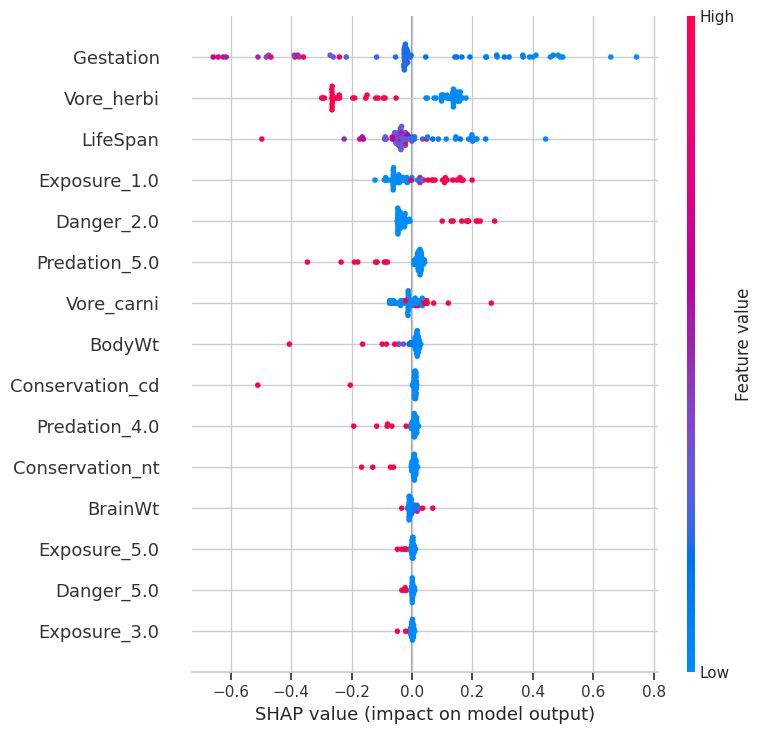

In [ ]:
# Initialize the SHAP Explainer
explainer = shap.Explainer(svr_best_d.predict, X_train_d)

# Compute SHAP values
shap_values = explainer(X_train_d)

# Summary Plot for overall feature importance  for Dreaming
shap.summary_plot(shap_values, X_train_d, feature_names=X_train_d.columns)

In [ ]:
# Accessing SHAP values
values = shap_values.values

# Converting SHAP values to a DataFrame for easier handling
shap_df = pd.DataFrame(values, columns=X_train_d.columns)

# Print the SHAP values DataFrame
print(shap_df)

     BrainWt    BodyWt  Vore_herbi  Exposure_1.0  Exposure_5.0  LifeSpan  \
0  -0.008001  0.020556    0.136790     -0.044121      0.001286 -0.054537   
1  -0.004892  0.021334    0.152275     -0.057097      0.001643 -0.022253   
2  -0.007983  0.004885    0.137050     -0.045238      0.001964 -0.050202   
3   0.004416  0.004009   -0.153219     -0.039504     -0.019742 -0.052831   
4  -0.005022  0.011178   -0.247642      0.110375      0.003165  0.143989   
..       ...       ...         ...           ...           ...       ...   
64  0.006250  0.020829    0.138175     -0.043681      0.003191 -0.045840   
65  0.021578 -0.006050    0.115480     -0.017409      0.001366 -0.024758   
66  0.001704  0.012633    0.097413     -0.000341      0.004813 -0.497562   
67 -0.007298  0.006317    0.136873     -0.047470      0.001004 -0.052762   
68 -0.009936  0.015698   -0.264471     -0.062904      0.000784 -0.036975   

    Conservation_cd  Gestation  Danger_5.0  Vore_carni  Predation_5.0  \
0          0.0